In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib.pyplot as plt
import torch

from toy_rnns import (
    LoRRNN,
    WeightedMSELoss,
    SparseIdentityData,
    SparseShiftedIdentityData,
    SparseCumulativeIdentityData,
    train,
)

In [ ]:
teacher_model = LoRRNN(n_features=10, n_neurons=15, rank=5)
loss_fn = WeightedMSELoss.from_exponential_curve(1.0)
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-3)
data = list(SparseIdentityData(10_000, num_features=10, num_timesteps=25, sparsity=0.999))

train(teacher_model, loss_fn, optimizer, data)

  0%|          | 0/10000 [00:00<?, ?it/s]

LoRRNN()

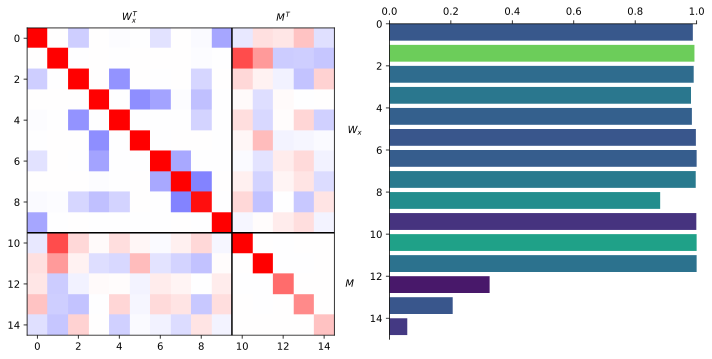

In [8]:
def plot_superposition(model: LoRRNN):
    weights = torch.concat([model.Wx, model.M], dim=1).detach()
    wtw2 = (weights.T @ weights) ** 2
    norm = torch.diag(wtw2)
    superposition = torch.sum(wtw2, dim=1) - torch.diag(wtw2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(weights.T @ weights, vmin=-1, vmax=1, cmap="bwr")
    ax1.hlines([10 - 0.5], [-0.5], [weights.shape[-1] - 0.5], colors=["black"])
    ax1.vlines([10 - 0.5], [-0.5], [weights.shape[-1] - 0.5], colors=["black"])
    ax1.annotate(
        "$W_x^T$",
        xy=(model.Wx.shape[1] / 2 - 0.5, 0),
        xytext=(model.Wx.shape[1] / 2 - 0.5, -0.75),
        ha="center",
        va="bottom",
        annotation_clip=False,
    )
    ax1.annotate(
        "$M^T$",
        xy=(model.Wx.shape[1] + model.M.shape[1] / 2 - 0.5, 0),
        xytext=(model.Wx.shape[1] + model.M.shape[1] / 2 - 0.5, -0.75),
        ha="center",
        va="bottom",
        annotation_clip=False,
    )
    ax1.annotate(
        "$W_x$",
        xy=(weights.shape[1], model.Wx.shape[1] / 2 - 0.5),
        xytext=(weights.shape[1] + 0.5, model.Wx.shape[1] / 2 - 0.5),
        ha="center",
        va="center",
        annotation_clip=False,
    )
    ax1.annotate(
        "$M$",
        xy=(
            weights.shape[1],
            model.Wx.shape[1] + model.M.shape[1] / 2 - 0.5,
        ),
        xytext=(
            weights.shape[1] + 0.25,
            model.Wx.shape[1] + model.M.shape[1] / 2 - 0.5,
        ),
        ha="center",
        va="center",
        annotation_clip=False,
    )

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, len(norm))
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position("top")
    ax2.invert_yaxis()
    for spine in ["bottom", "right"]:
        ax2.spines[spine].set_visible(False)
    ax2.barh(
        range(len(norm)),
        norm,
        align="edge",
        color=plt.get_cmap("viridis")(superposition),
    )

    fig.tight_layout()
    plt.show()

plot_superposition(teacher_model)

torch.Size([5, 25])
torch.Size([10, 25])


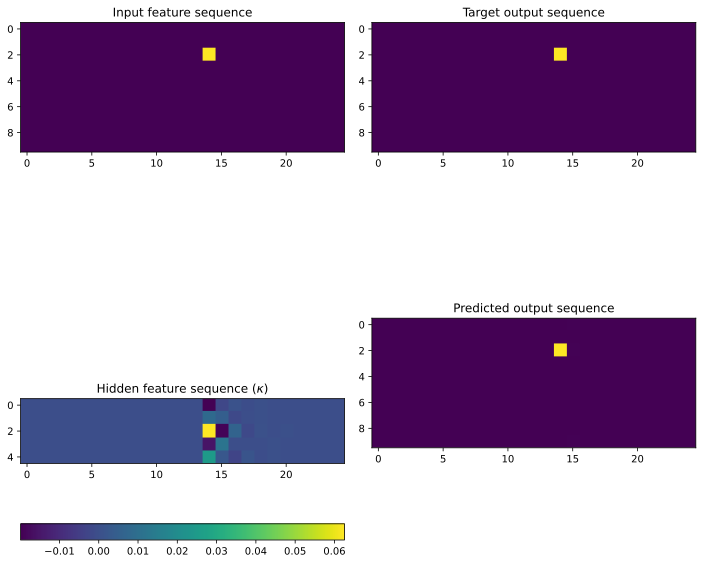

In [14]:
test_data = data

for x, y in data:
    if (x == 0).all():
        continue

    teacher_model.reset_h()
    n_timesteps = x.shape[-1]
    y_pred = torch.empty_like(y)
    kappas = []
    for t in range(n_timesteps):
        y_pred[:, t] = teacher_model(x[:, t])
        kappas.append(teacher_model.kappa.detach())
    kappas = torch.stack(kappas, dim=1)
    print(kappas.shape)
    print(x.shape)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    ax1.imshow(x)
    ax1.set_title("Input feature sequence")
    ax2.imshow(y)
    ax2.set_title("Target output sequence")
    kappaplot = ax3.imshow(kappas)
    ax3.set_title(r"Hidden feature sequence ($\kappa$)")
    predplot = ax4.imshow(y_pred.detach())
    ax4.set_title("Predicted output sequence")

    fig.colorbar(kappaplot, orientation="horizontal")
    fig.tight_layout()
    plt.show()

    break